In [120]:
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

Text(0.5, 1.0, 'Apple stock')

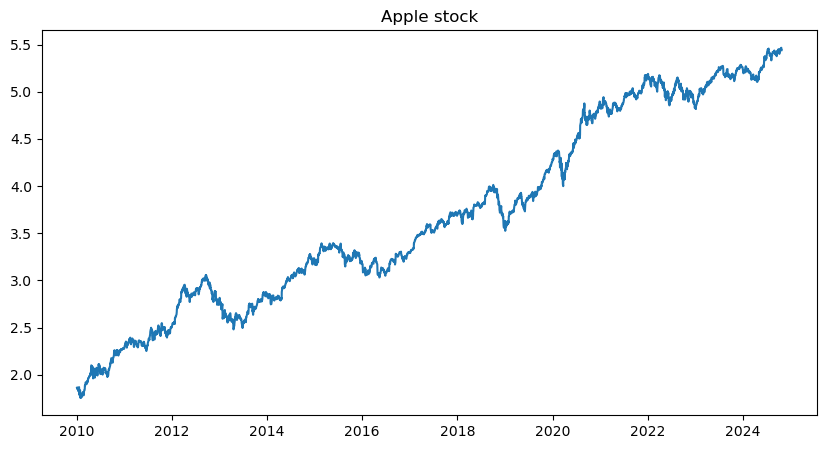

In [140]:
aapl = yf.Ticker('AAPL')
AAPL = aapl.history(start="2010-01-01")

df = np.log(AAPL[['Close']])
df['Time'] = np.arange(len(AAPL_log))

fig = plt.figure(figsize=(10,5))
plt.plot(df['Close'])
plt.title('Apple stock')

In [141]:
#Split the data
y = df['Close']
X = df['Time']

idx_train, idx_test = train_test_split(
    y.index, test_size=0.2, shuffle=False,
)

X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]



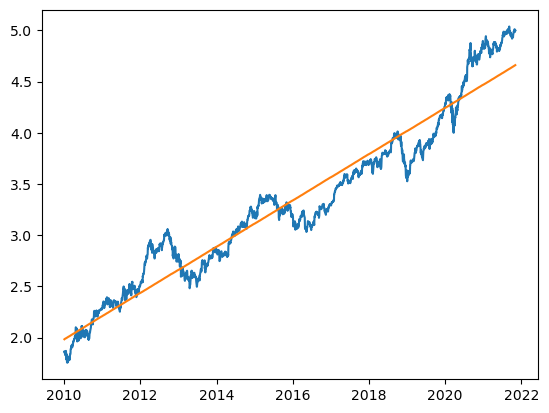

In [142]:
#Fit linear regression to data
X_pd = X_train.to_frame()

model = LinearRegression()
model.fit(X_pd, y_train)

predictions = pd.Series(model.predict(X_pd), index=X_pd.index)

plt.plot(y_train)
plt.plot(predictions)

Text(0.5, 1.0, 'Residuals of linear fit')

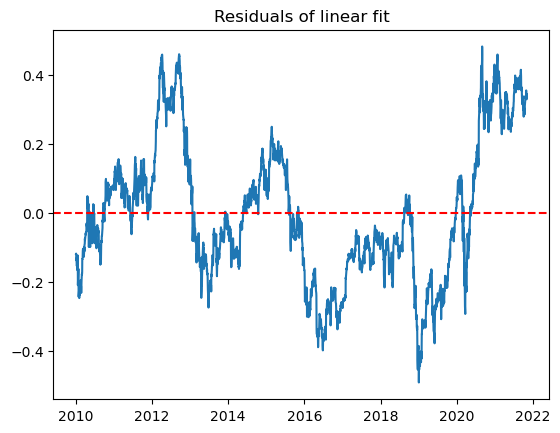

In [143]:
res = pd.Series(y_train - predictions, index=y_train.index)
plt.plot(res)
plt.axhline(res.mean(), color='red', linestyle='--')
plt.title('Residuals of linear fit')

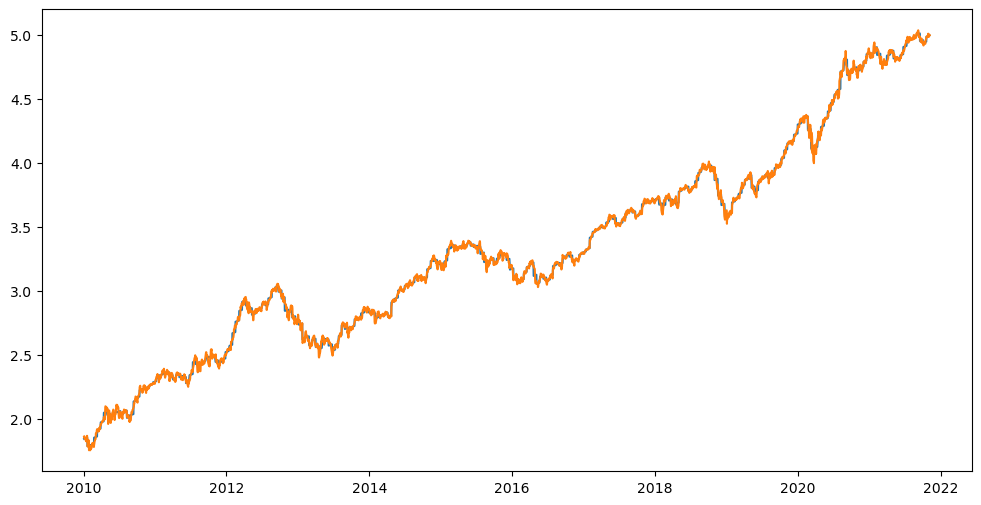

In [144]:
#XGBoost for residuals
from xgboost import XGBRegressor

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, res)

# Add the predicted residuals onto the predicted trends
predictions_boosted = xgb.predict(X_train) + predictions
_ = plt.figure(figsize=(12,6))
plt.plot(predictions_boosted)
plt.plot(y_train)

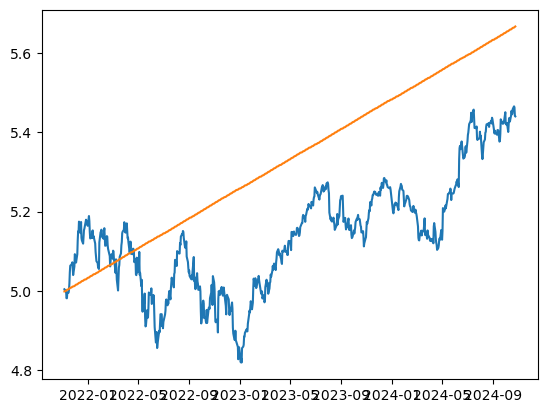

In [145]:
#Check future predictions
X_test_pd = X_test.to_frame()

linear_predictions = pd.Series(model.predict(X_test_pd), index=X_test.index)
future_pred = xgb.predict(X_test) + linear_predictions
plt.plot(y_test)
plt.plot(future_pred)

## Using lag features

In [81]:
df['Lag1'] = df['Close'].shift(1)
df.head()

,Close,Time,Lag1
Date,,,
2010-01-04 00:00:00-05:00,1.864778,0,NaN
2010-01-05 00:00:00-05:00,1.866506,1,1.864778
2010-01-06 00:00:00-05:00,1.850472,2,1.866506
2010-01-07 00:00:00-05:00,1.848621,3,1.850472
2010-01-08 00:00:00-05:00,1.855248,4,1.848621


/var/folders/4z/2g96pmwd6xl1ctlh7l8scd8c0000gn/T/ipykernel_8986/1784071766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace = True)


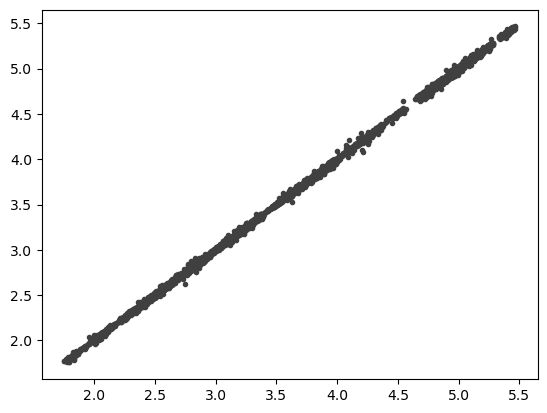

In [88]:
X = df[['Lag1']]
y = df['Close']

X.dropna(inplace = True)
y, X = y.align(X, join='inner')

plt.plot(X,y, '.', color='0.25')

Text(0.5, 1.0, 'Residuals')

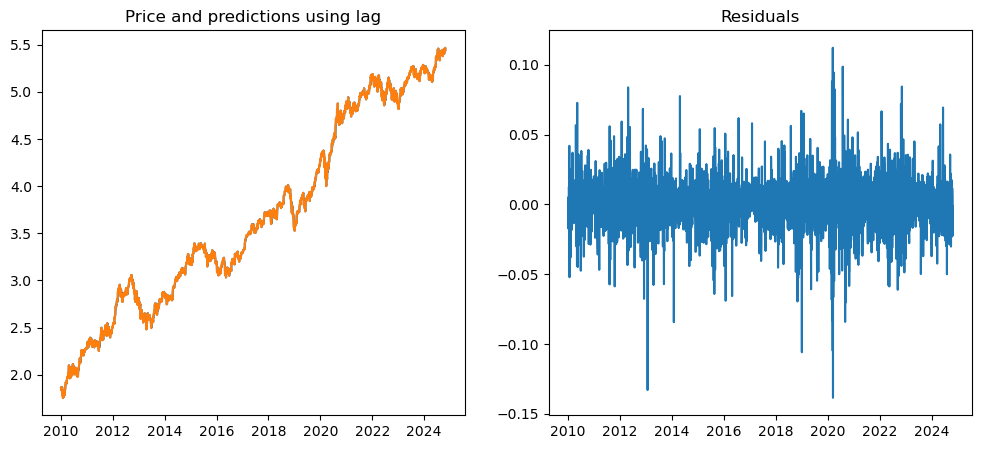

In [95]:
model_lag = LinearRegression()
model_lag.fit(X, y)

preds = pd.Series(model_lag.predict(X), index=X.index)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].plot(preds)
ax[0].plot(y)
ax[0].set_title('Price and predictions using lag')
ax[1].plot(y-preds)
ax[1].set_title('Residuals')

In [96]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

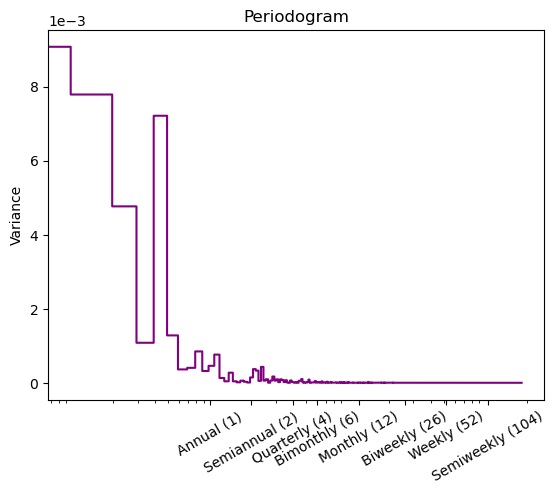

In [97]:
plot_periodogram(df.Close);